# DREEM Demo

This notebook will walk you through the DREEM pipeline, end to end. Here, we'll use the API, but we also provide a CLI interface for convenience. For each step, we provide the relevant CLI command.

To run this demo, we have provided sample data, model checkpoints, and configurations. The data used in this demo is small enough to be run on a single machine without a GPU. 

#### Directory structure:
```
./data
     three_flies.mp4
     three_flies.slp
     two_flies.mp4
     two_flies.slp
 ./models
     pretrained/
         epoch=18-val_loss=1.987402319908142.ckpt
 ./configs
     base.yaml
 dreem-demo.ipynb
 ```

In [ ]:
import torch
import pandas as pd
import numpy as np
import os
from pathlib import Path
from datetime import datetime
import pytorch_lightning as pl
from omegaconf import OmegaConf
from dreem.io import Config
from dreem.datasets import TrackingDataset
from dreem.models import GTRRunner
from dreem.inference import Tracker
import sleap_io as sio
import matplotlib.pyplot as plt

Check if a GPU is available. For Apple silicon users, you can run on MPS, but ensure your version of PyTorch is compatible with MPS, and that you have installed the correct version of DREEM. You can also run without a GPU. The demo has been tested on an M3 Macbook Air running only on a CPU.


In [2]:
cuda_available = torch.cuda.is_available()
print(f"CUDA available: {cuda_available}")
if cuda_available:
    accelerator = "cuda"
elif torch.backends.mps.is_available():
    accelerator = "mps"
    devices = 1
else:
    accelerator = "cpu"
print("Using device: ", accelerator)

torch.set_float32_matmul_precision("medium")

CUDA available: True
Using device:  cuda


##### If you would like to skip the training process, you can go straight to the "Inference" section

## Training

#### Setup configs
The configs provided are good defaults. You can change them as you see fit.

In [41]:
config_path = "./configs/base.yaml"
# use OmegaConf to load the config
cfg = OmegaConf.load(config_path)
train_cfg = Config(cfg)

#### Create a model
The model is a Lightning wrapper around our model. Lightning simplifies training, validation, logging, and checkpointing.

In [42]:
model = train_cfg.get_gtr_runner()

`tracker` not found in config or is empty. Using defaults for tracker_cfg!


#### Prepare torch datasets and dataloader
Note: We use a batch size of 1 - we handle the batching ourselves since we are dealing with video data and associated labels in .slp format. The default clip length is set to 32 frames.

In [43]:
train_dataset = train_cfg.get_dataset(mode="train")
train_dataloader = train_cfg.get_dataloader(train_dataset, mode="train")

val_dataset = train_cfg.get_dataset(mode="val")
val_dataloader = train_cfg.get_dataloader(val_dataset, mode="val")

# wrap the dataloaders
dataset = TrackingDataset(train_dl=train_dataloader, val_dl=val_dataloader)

#### Visualize the input data
The input data to the model is a set of crops taken around a particular keypoint on the instance. For animals, this can be any keypoint, and for microscopy, this is often the centroid. Augmentations are also applied. Since we shuffle the data, the frame ids you get may not be the first frames of the video.

In [46]:
# load a batch of data in
viewer = iter(train_dataloader)
batch = next(viewer)
# save the crops for all frames in the batch
crops = {}
for frame in batch[0]:
    crops[frame.frame_id.item()] = []
    for instance in frame.instances:
        crops[frame.frame_id.item()].append(instance.crop.squeeze().permute(1,2,0).numpy())

Plot the crops for all frames in the batch

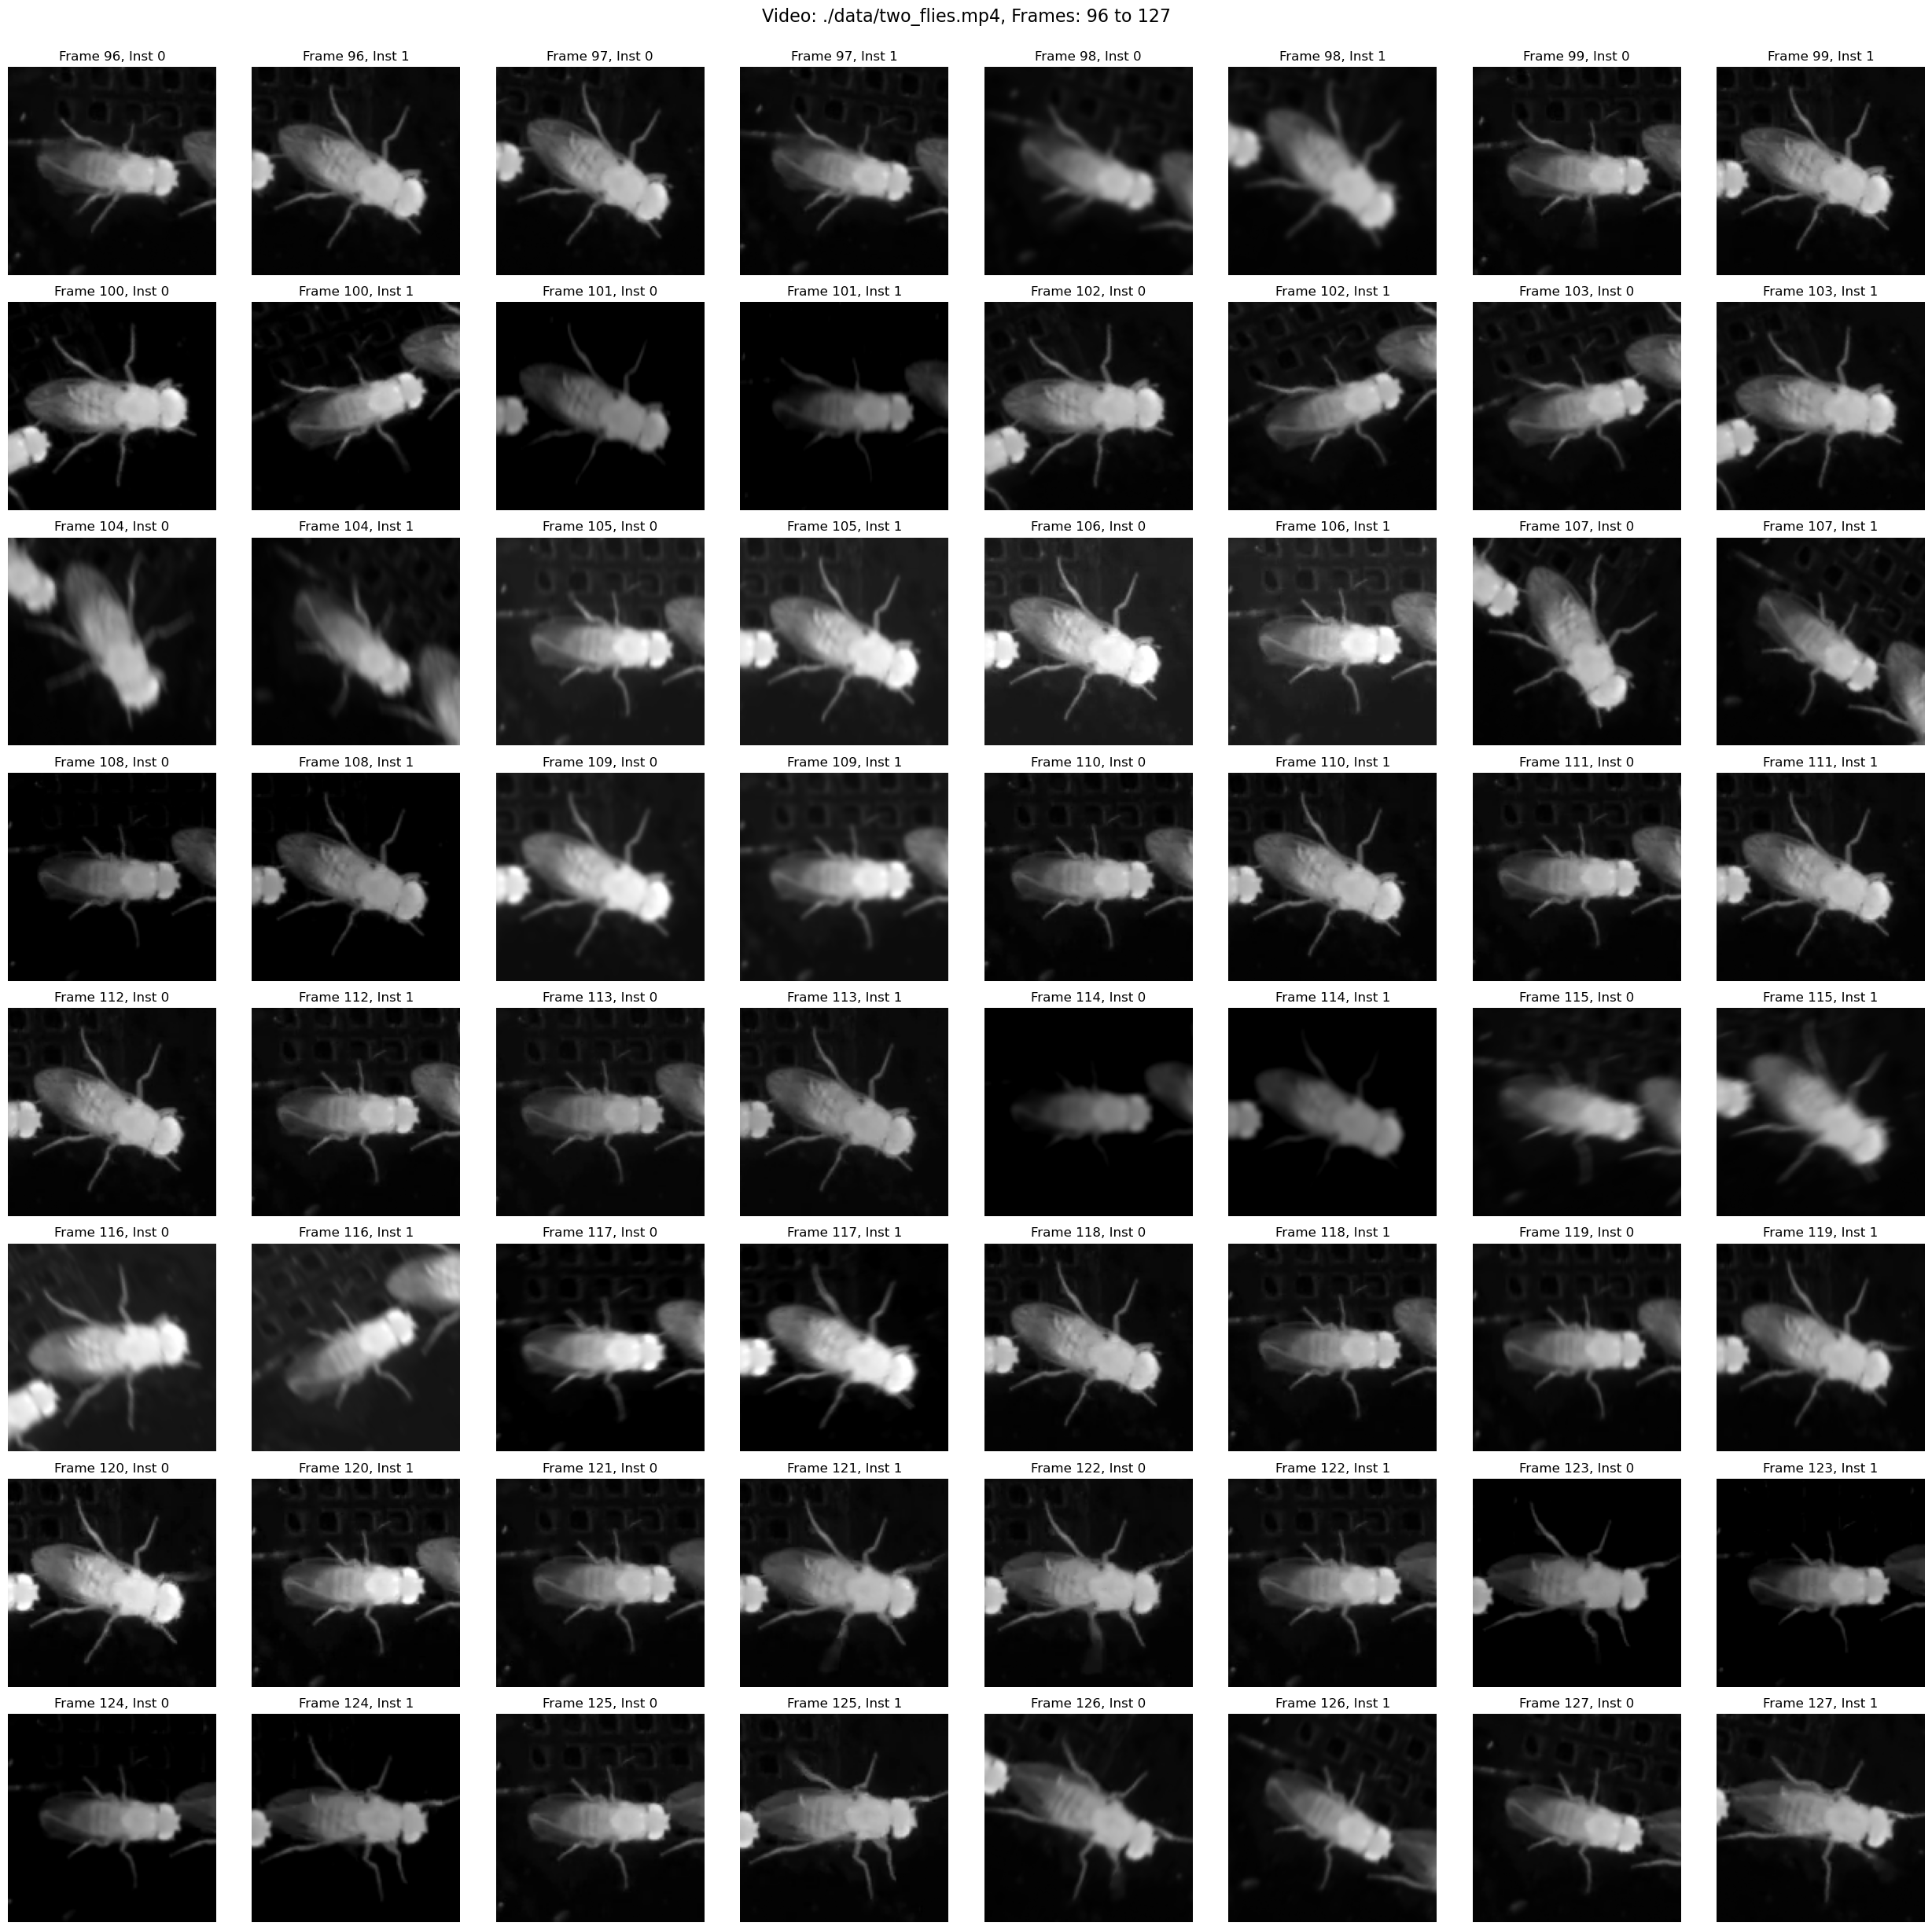

In [47]:
total_crops = sum(len(crops) for crops in crops.items())

# Determine a grid size
n_cols = int(np.ceil(np.sqrt(total_crops)))
n_rows = int(np.ceil(total_crops / n_cols))

# Create figure and axes
fig, axes = plt.subplots(n_rows, n_cols, figsize=(25,25))
fig.suptitle(f"Video: {frame.video}, Frames: {min(crops.keys())} to {max(crops.keys())}", fontsize=16)

# Ensure axes is always a 2D array
if n_rows == 1 and n_cols == 1: axes = np.array([[axes]])
elif n_rows == 1: axes = axes.reshape(1, -1)
elif n_cols == 1: axes = axes.reshape(-1, 1)

# Flatten for easier indexing
axes_flat = axes.flatten()

# Plot each crop
ax_idx = 0
for frame_id, vid_crops in sorted(crops.items()):
    for i, crop in enumerate(vid_crops):
        if ax_idx < len(axes_flat):
            ax = axes_flat[ax_idx]
            
            # Handle both RGB and grayscale images
            if crop.ndim == 3:
                # Normalize if needed
                if crop.max() > 1.0:
                    crop = crop / 255.0
                ax.imshow(crop)
            else:
                ax.imshow(crop, cmap='gray')
            
            ax.set_title(f"Frame {frame_id}, Inst {i}")
            ax.axis('off')
            ax_idx += 1

# Hide unused subplots
for i in range(ax_idx, len(axes_flat)):
    axes_flat[i].axis('off')

# Adjust layout to minimize whitespace
plt.tight_layout()
plt.subplots_adjust(top=0.95) 

#### Train the model
First setup various training features such as loss curve plotting, early stopping and more, through Lightning's callbacks, then setup the Trainer and train the model.

In [14]:
# to plot loss curves 
class NotebookPlotCallback(pl.Callback):
    def __init__(self):
        super().__init__()
        self.train_losses = []
        self.val_losses = []
        self.epochs = []
        
    def on_train_epoch_end(self, trainer, pl_module):
        train_loss = trainer.callback_metrics.get('train_loss')
        self.train_losses.append(train_loss.item())
        self.epochs.append(trainer.current_epoch)
    
    def on_validation_epoch_end(self, trainer, pl_module):
        val_loss = trainer.callback_metrics.get('val_loss')
        self.val_losses.append(val_loss.item())

notebook_plot_callback = NotebookPlotCallback()

In [15]:
callbacks = []
_ = callbacks.extend(train_cfg.get_checkpointing())
_ = callbacks.append(pl.callbacks.LearningRateMonitor())
early_stopping = train_cfg.get_early_stopping()
if early_stopping is not None:
    callbacks.append(early_stopping)
callbacks.append(notebook_plot_callback)

The default maximum epochs is set to 5 in the provided config. You can change this in the trainer section of the config.

In [16]:
# setup Lightning Trainer
trainer = train_cfg.get_trainer(
    callbacks,
    accelerator=accelerator,
    devices=1
)
# train the model
trainer.fit(model, dataset)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
`Trainer(limit_test_batches=1.0)` was configured so 100% of the batches will be used..


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name  | Type                      | Params | Mode
-----------------------------------------------------------
0 | model | GlobalTrackingTransformer | 11.5 M | eval
1 | loss  | AssoLoss                  | 0      | eval
-----------------------------------------------------------
11.5 M    Trainable params
0         Non-trainable params
11.5 M    Total params
46.174    Total estimated model params size (MB)
0         Modules in train mode
145       Modules in eval mode


Epoch 0: 100%|██████████| 4/4 [00:11<00:00,  0.35it/s, v_num=10]           

Epoch 0, global step 4: 'val_loss' reached 0.68942 (best 0.68942), saving model to '/root/vast/mustafa/dreem-experiments/notebooks/dreem-demo/models/example_train/epoch=0-val_loss=0.6894235610961914.ckpt' as top 1


Epoch 1: 100%|██████████| 4/4 [00:12<00:00,  0.32it/s, v_num=10]

Epoch 1, global step 8: 'val_loss' reached 0.67331 (best 0.67331), saving model to '/root/vast/mustafa/dreem-experiments/notebooks/dreem-demo/models/example_train/epoch=1-val_loss=0.6733112931251526.ckpt' as top 1


Epoch 2: 100%|██████████| 4/4 [00:12<00:00,  0.33it/s, v_num=10]

Epoch 2, global step 12: 'val_loss' reached 0.65919 (best 0.65919), saving model to '/root/vast/mustafa/dreem-experiments/notebooks/dreem-demo/models/example_train/epoch=2-val_loss=0.6591916084289551.ckpt' as top 1


Epoch 3: 100%|██████████| 4/4 [00:11<00:00,  0.35it/s, v_num=10]

Epoch 3, global step 16: 'val_loss' reached 0.64768 (best 0.64768), saving model to '/root/vast/mustafa/dreem-experiments/notebooks/dreem-demo/models/example_train/epoch=3-val_loss=0.6476808786392212.ckpt' as top 1


Epoch 4: 100%|██████████| 4/4 [00:11<00:00,  0.36it/s, v_num=10]

Epoch 4, global step 20: 'val_loss' reached 0.63546 (best 0.63546), saving model to '/root/vast/mustafa/dreem-experiments/notebooks/dreem-demo/models/example_train/epoch=4-val_loss=0.6354552507400513.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 4/4 [00:12<00:00,  0.33it/s, v_num=10]


#### Visualize the train and validation loss curves

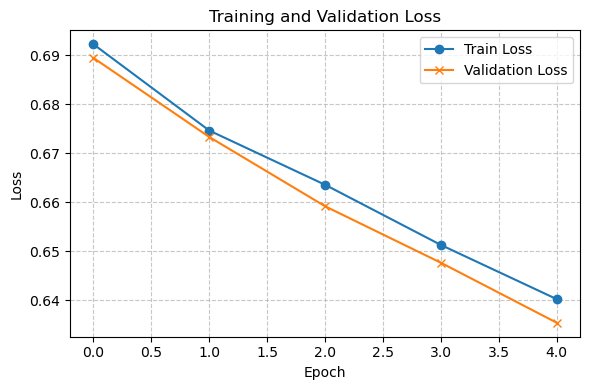

In [17]:
plt.figure(figsize=(6,4))
plt.plot(notebook_plot_callback.epochs, notebook_plot_callback.train_losses, label='Train Loss', marker='o')
plt.plot(notebook_plot_callback.epochs, notebook_plot_callback.val_losses[1:], label='Validation Loss', marker='x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Inference

#### Use the best checkpoint from the model you just trained, or load a pretrained model

In [18]:
# set this to True to use a pretrained model
use_pretrained = False

In [19]:
pretrained_ckpt = "./models/pretrained/epoch=18-val_loss=1.987402319908142.ckpt"
if use_pretrained:
    model = GTRRunner.load_from_checkpoint(pretrained_ckpt)
else:
    # get the model from the directory it saves to 
    # (see logging.name in the config)
    ckpt_dir = "./models/example_train"
    ckpts = os.listdir(ckpt_dir)
    for ckpt in ckpts:
        if "final" in ckpt: # assumes the final checkpoint is the best one
            best_checkpoint_path = os.path.join(ckpt_dir, ckpt)
            break
    model = GTRRunner.load_from_checkpoint(best_checkpoint_path)

### Setup inference configs

In [20]:
pred_cfg_path = "./configs/inference.yaml"
# use OmegaConf to load the config
pred_cfg = OmegaConf.load(pred_cfg_path)
pred_cfg = Config(pred_cfg)

Get the tracker settings from the config and initialize the tracker

In [21]:
tracker_cfg = pred_cfg.get_tracker_cfg()
model.tracker_cfg = tracker_cfg
model.tracker = Tracker(**model.tracker_cfg)
trainer = pred_cfg.get_trainer()
# inference results will be saved here
outdir = "./results"
os.makedirs(outdir, exist_ok=True)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer(limit_test_batches=1.0)` was configured so 100% of the batches will be used..


### Prepare data and run inference

In [33]:
labels_files, vid_files = pred_cfg.get_data_paths(pred_cfg.cfg.dataset.test_dataset)

for label_file, vid_file in zip(labels_files, vid_files):
    dataset = pred_cfg.get_dataset(
        label_files=[label_file], vid_files=[vid_file], mode="test"
    )
    dataloader = pred_cfg.get_dataloader(dataset, mode="test")
    
    # the actual inference is done here
    preds = trainer.predict(model, dataloader)

    # convert the predictions to sleap format
    pred_slp = []
    tracks = {}
    for batch in preds:
        for frame in batch:
            if frame.frame_id.item() == 0:
                video = (
                    sio.Video(frame.video)
                    if isinstance(frame.video, str)
                    else sio.Video
                )
            lf, tracks = frame.to_slp(tracks, video=video)
            pred_slp.append(lf)
    pred_slp = sio.Labels(pred_slp)
    # save the predictions to disk (requires sleap-io)
    outpath = os.path.join(
        outdir, f"{Path(label_file).stem}.dreem_inference.{datetime.now().strftime('%m-%d-%Y-%H-%M-%S')}.slp"
    )
    pred_slp.save(outpath)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:11<00:00,  0.34it/s]


## Visualize the results

In [59]:
import cv2
import matplotlib.colors as mcolors
from matplotlib.animation import FuncAnimation
from matplotlib.patches import Circle
import matplotlib.cm as cm
from IPython.display import HTML, display
import io
import base64
from IPython.display import Video

def create_animal_tracking_animation_notebook(video_path, metadata_df, 
                                             fps=30, text_size=8, marker_size=20,
                                             max_frames=None, display_width=800):
    """
    Create and display an animal tracking animation directly in the notebook.
    
    Parameters:
    -----------
    video_path : str
        Path to the input MP4 video file
    metadata_df : pandas.DataFrame
        DataFrame with columns: frame_id, track_id, centroid
    fps : int
        Frames per second for the animation
    text_size : int
        Size of the ID text
    marker_size : int
        Size of the marker circle
    max_frames : int, optional
        Maximum number of frames to process (useful for previewing)
    display_width : int
        Width of the displayed animation in the notebook
    """
    # Open the video file
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        raise ValueError(f"Could not open video file: {video_path}")
    
    # Get video properties
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    # Create a colormap for track IDs
    unique_ids = metadata_df['track_id'].unique()
    cmap = cm.get_cmap('tab10', len(unique_ids))  # Using 'hsv' for bright, distinct colors
    id_to_color = {id_val: cmap(i) for i, id_val in enumerate(unique_ids)}
    
    # Set up the figure and axis with the correct aspect ratio
    fig_width = display_width / 100  # Convert to inches (assuming 100 dpi)
    fig_height = fig_width * (height / width)
    fig, ax = plt.subplots(figsize=(fig_width, fig_height))
    
    # Initialize the plot elements
    frame_img = ax.imshow(np.zeros((height, width, 3), dtype=np.uint8))
    markers = []
    texts = []
    
    # Get the list of frame IDs from the metadata
    frame_ids = sorted(metadata_df['frame_id'].unique())
    
    # Limit the number of frames if specified
    if max_frames is not None and max_frames < len(frame_ids):
        frame_ids = frame_ids[:max_frames]
        print(f"Limiting preview to {max_frames} frames")
    
    # Function to update the animation for each frame
    def update(frame_num):
        # Read the frame from the video
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_num)
        ret, frame = cap.read()
        if not ret:
            print(f"Failed to read frame {frame_num}")
            return []
        
        # Convert BGR to RGB (OpenCV uses BGR, matplotlib uses RGB)
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame_img.set_array(frame_rgb)
        
        # Clear previous markers and texts
        for marker in markers:
            marker.remove()
        markers.clear()
        
        for text in texts:
            text.remove()
        texts.clear()
        
        # Get data for the current frame
        frame_data = metadata_df[metadata_df['frame_id'] == frame_num]
        
        # Add markers and IDs for each animal in the current frame
        for _, row in frame_data.iterrows():
            track_id = row['track_id']
            x, y = row['centroid']
            color = id_to_color[track_id]
            
            # Add circle marker
            circle = Circle((x, y), marker_size, color=color, alpha=0.7)
            markers.append(ax.add_patch(circle))
            
            # Add ID text
            text = ax.text(x, y, str(track_id), color='white', 
                          fontsize=text_size, ha='center', va='center', 
                          fontweight='bold')
            texts.append(text)
        
        # Add frame number for reference
        frame_text = ax.text(10, 20, f"Frame: {frame_num}", color='white', 
                            fontsize=text_size, backgroundcolor='black')
        texts.append(frame_text)
        
        return [frame_img] + markers + texts
    
    # Set up the axis
    ax.set_xlim(0, width)
    ax.set_ylim(height, 0)  # Invert y-axis to match image coordinates
    ax.axis('off')
    
    # Create the animation
    print(f"Creating animation with {len(frame_ids)} frames...")
    anim = FuncAnimation(fig, update, frames=frame_ids, blit=True)
    
    # Display the animation in the notebook
    plt.close(fig)  # Prevent duplicate display
    
    # Display as HTML5 video
    html_video = HTML(anim.to_html5_video())
    display(html_video)
    
    return anim

# Option to save the animation to a file for later viewing
def save_animation(anim, output_path, fps=10, dpi=100):
    """Save the animation to a file"""
    anim.save(output_path, writer='ffmpeg', fps=fps, dpi=dpi)
    print(f"Animation saved to {output_path}")
    
    # Display the saved video in the notebook
    return Video(output_path, embed=True, width=800)

Load the predictions into a dataframe to make an animation

In [52]:
list_frames = []
for lf in pred_slp:
    for instance in lf.instances:
        centroid = np.nanmean(instance.numpy(), axis=0)
        track_id = int(instance.track.name)
        list_frames.append({'frame_id': lf.frame_idx, 'track_id': track_id, 'centroid': centroid})
df = pd.DataFrame(list_frames)

Create and display the animation in the notebook

In [61]:
anim = create_animal_tracking_animation_notebook(
    video_path="./data/three_flies.mp4",
    metadata_df=df,
    fps=10,
    text_size=8,
    marker_size=20,
    max_frames=150
)

# save the animation
video = save_animation(anim, "./animal_tracking_vis.mp4")

/tmp/ipykernel_2498080/3945403949.py:46: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab10', len(unique_ids))  # Using 'hsv' for bright, distinct colors


Creating animation with 128 frames...


Animation saved to ./animal_tracking_vis.mp4
